## Michelle Kouba
## Text Processing Skills and Recurrent Neural Networks

In [ ]:
# Mounting my drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/GitHub/dsc650/dsc650/assignments/assignment09')
!pwd

Mounted at /content/drive
/content/drive/My Drive/GitHub/dsc650/dsc650/assignments/assignment09


In [ ]:
# Importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from pathlib import Path
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop

## Function to create Tokens

In [ ]:
# Data Pre-processing
# Creating a function that turns the sentences into words (tokens) and strips punctuation and upper-case letters
def tokenize(sentence):
    tokens = []
    # Splitting sentence into words
    words = sentence.split()
    # Converting all words to lowercase
    words = [word.lower() for word in words]
    # Removing all punctuation
    translator = str.maketrans('', '', string.punctuation)
    tokens = [word.translate(translator) for word in words]
    return tokens


## Function that creates ngrams from Tokens

In [ ]:
# Creating an ngram that splits tokens into N-grams
def ngram(token, n):
    ngrams = []
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]
    return ngrams

In [ ]:
text = "If at first you don't succeed, try, try again."
words_token = tokenize(text)
print(words_token)


['if', 'at', 'first', 'you', 'dont', 'succeed', 'try', 'try', 'again']


In [ ]:
tokens_ngrams = ngram(words_token, 4)
print(tokens_ngrams)

['if at first you', 'at first you dont', 'first you dont succeed', 'you dont succeed try', 'dont succeed try try', 'succeed try try again']


## Function Using One-Hot Encoding to Create a Numerical Vector from the Tokens

In [ ]:
# Implement an one_hot_encode function to create a vector from a numerical vector from a list of tokens.
# Function encoding a list of tokens.
def one_hot_encode(tokens, num_words):
    # Initializing the dictionary to hold each unique token with its index number
    token_index = {}
    # Adding each token to the index if it's not already there (index is plus one because of the padding token).
    for word in tokens:
        if word not in token_index:
            token_index[word] = len(token_index) + 1  # We add 1 to the index because 0 is the padding token
        # Otherwise returning nothing
        results = ''
    max_length = 10
    # Results will hold the one-hot encoded tokens
    results = np.zeros(shape=(len(tokens), max_length, max(token_index.values()) + 1))  # We add 1 to the vocabulary size to account for the padding token
    # Iterating over the tokens and their indices, and one-hot encode them
    for i, word in enumerate(tokens):
        for j, word in list(enumerate(tokens))[:max_length]:  # Limiting the words to max length
            index = token_index.get(word)
            results[i, j, index] = 1
    return results # A numpy array of shape where first argument is number of tokens, second argument max length of the token sequence and third is the size of the vocabulary plus one for the padding token)

## Training a Keras Sequential Model (With Embeddings) on IMDB data

In [ ]:
# Train a sequential model with embeddings on the IMDB data
# Set the directories/paths
current_dir = Path(os.getcwd()).absolute()
imdb_dir = '../../data/external/imdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
test_dir = os.path.join(imdb_dir, 'test')

In [ ]:
# Process the labels of the raw IMDB data
# Review labels will be assigned (0 for negative, 1 for positive)
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)

    # Iterate over the files in the directory and extract the text data
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [ ]:
# Tokenizing the text of the raw IMDB data

# Setting parameters
# Cutting off the reviews after 100 words
maxlen = 100
# Training on 200 samples
training_samples = 200
# Validating on 10000 samples
validation_samples = 10000
# Only using the top 10000 words in the dataset
max_words = 10000

# Creating a tokenizer object
tokenizer = Tokenizer(num_words=max_words)
# Fitting to the texts
tokenizer.fit_on_texts(texts)
# Converting the texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Get the word index from the tokenizer
word_index = tokenizer.word_index
# Printing unique number of tokens
print(f'Unique Tokens: {len(word_index)} ')

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print(f'Data tensor: {data.shape}')
print(f'Label tensor: {labels.shape}')

# Shuffle the data since the data is filtered all negative first, then positive
# Otherwise splitting the data would be negative vs positive.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Splitting the data/labels into training/validation sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Unique Tokens: 88582 
Data tensor: (25000, 100)
Label tensor: (25000,)


In [ ]:
# Defining the model (6.16)
embedding_dim = 100
# Creating a sequential model
model = Sequential()
# Adding an embedding layer
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# Adding a flattening layer
model.add(Flatten())
# Adding a dense layer
model.add(Dense(32, activation='relu'))
# Adding another a dense layer
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training and evaluating the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Training the model on the training data and evaluating it on the validation data
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_model.h5')

Epoch 1/10
7/7 [==============================] - 8s 263ms/step - loss: 0.6905 - acc: 0.5550 - val_loss: 0.6939 - val_acc: 0.4994
Epoch 2/10
7/7 [==============================] - 2s 235ms/step - loss: 0.5507 - acc: 0.9800 - val_loss: 0.7007 - val_acc: 0.5048
Epoch 3/10
7/7 [==============================] - 2s 233ms/step - loss: 0.3896 - acc: 0.9800 - val_loss: 0.7071 - val_acc: 0.5115
Epoch 4/10
7/7 [==============================] - 2s 233ms/step - loss: 0.2307 - acc: 1.0000 - val_loss: 0.7252 - val_acc: 0.5148
Epoch 5/10
7/7 [==============================] - 1s 184ms/step - loss: 0.1310 - acc: 1.0000 - val_loss: 0.7411 - val_acc: 0.5139
Epoch 6/10
7/7 [==============================] - 1s 183ms/step - loss: 0.0745 - acc: 1.0000 - val_loss: 0.7285 - val_acc: 0.5144
Epoch 7/10
7/7 [==============================] - 1s 214ms/step - loss: 0.0449 - acc: 1.0000 - val_loss: 0.7518 - val_acc: 0.5128
Epoch 8/10
7/7 [==============================] - 1s 164ms/step - loss: 0.0287 - acc: 1.00

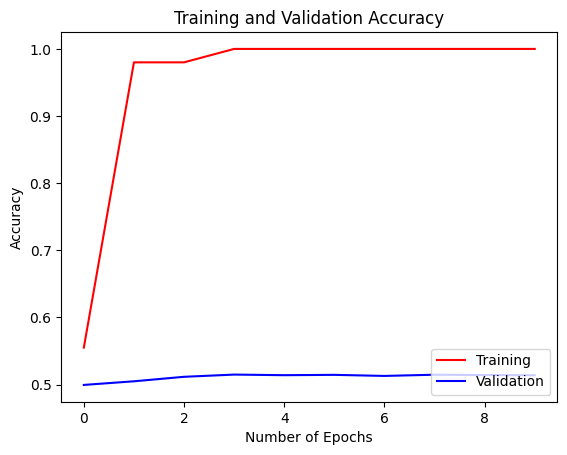

In [ ]:
# Plotting the results
# Plotting the training and validation accuracy curves
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

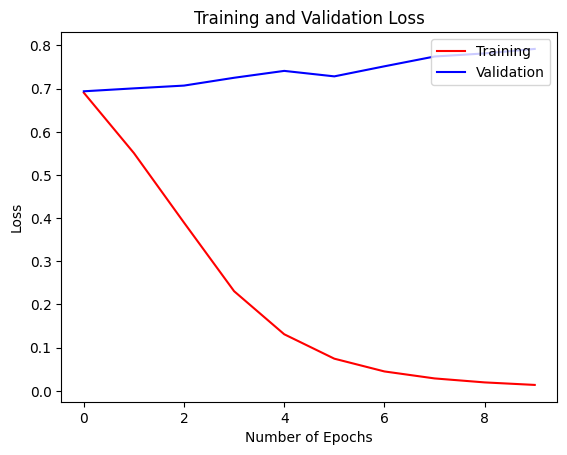

In [ ]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Tokenizing the data of the test set
test_dir = os.path.join(imdb_dir, 'test')
# Review labels will be assigned (0 for negative, 1 for positive)
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)

    # Iterate over the files in the directory and extract the text data
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [ ]:
# Loading and evaluating the model on the test set
model.load_weights('pre_trained_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.7931 - acc: 0.5146


[0.7930888533592224, 0.5145599842071533]

In [ ]:
# The model's accuracy is 51.5% and the model's loss is 0.79.

## Training the same model with a LSTM layer

In [ ]:
# Using the LSTM layer in Keras
max_features=10000
# Compiling model with LSTM layer
model = Sequential()
# Add an embedding layer
model.add(Embedding(max_features, 32))
# Add an LSTM layer
model.add(LSTM(32))
# Add a dense layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Training the model on the training data and validation data
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
2/2 [==============================] - 3s 608ms/step - loss: 0.6932 - acc: 0.5250 - val_loss: 0.6918 - val_acc: 0.5500
Epoch 2/10
2/2 [==============================] - 0s 186ms/step - loss: 0.6920 - acc: 0.5125 - val_loss: 0.6922 - val_acc: 0.5500
Epoch 3/10
2/2 [==============================] - 0s 187ms/step - loss: 0.6911 - acc: 0.5125 - val_loss: 0.6925 - val_acc: 0.5500
Epoch 4/10
2/2 [==============================] - 0s 191ms/step - loss: 0.6901 - acc: 0.5188 - val_loss: 0.6927 - val_acc: 0.5250
Epoch 5/10
2/2 [==============================] - 0s 189ms/step - loss: 0.6888 - acc: 0.6812 - val_loss: 0.6915 - val_acc: 0.5500
Epoch 6/10
2/2 [==============================] - 0s 189ms/step - loss: 0.6873 - acc: 0.5188 - val_loss: 0.6905 - val_acc: 0.5500
Epoch 7/10
2/2 [==============================] - 0s 192ms/step - loss: 0.6853 - acc: 0.5125 - val_loss: 0.6900 - val_acc: 0.5500
Epoch 8/10
2/2 [==============================] - 0s 193ms/step - loss: 0.6834 - acc: 0.51

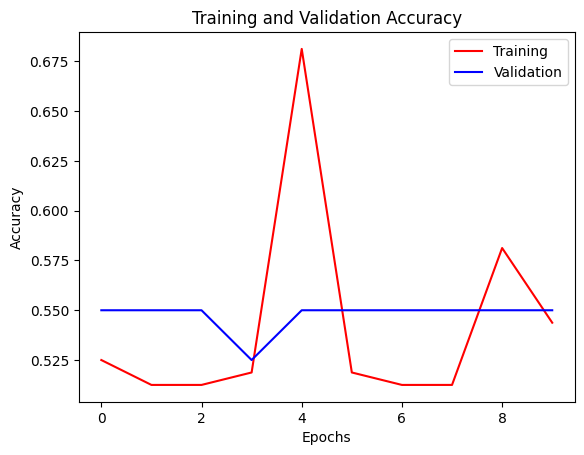

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

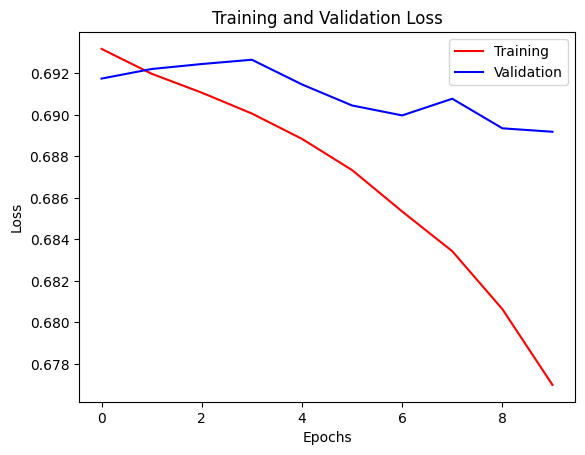

In [ ]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
# Evaluating the model
model.evaluate(x_test, y_test)

782/782 [==============================] - 3s 3ms/step - loss: 0.6909 - acc: 0.5136


[0.6909104585647583, 0.5136399865150452]

In [ ]:
# The model's accuracy is 51.4% and the model's loss is 0.69.

## Training a Simple 1D Convnet

In [ ]:
# Assignment 10.4 Fitiing the same data with a simple 1D convnet
# Creating a sequential model
model = Sequential()
# Adding an embedding layer
model.add(Embedding(max_features, 128, input_length=100))
# Adding a 1D convolutional layer
model.add(Conv1D(32, 7, activation='relu'))
# Adding a max pooling layer
model.add(MaxPooling1D(5))
# Adding another 1D convolutional layer
model.add(Conv1D(32, 7, activation='relu'))
# Adding a global max pooling layer
model.add(GlobalMaxPooling1D())
# Adding a dense layer
model.add(Dense(1))
model.summary()
# Compiling the model
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])
# Training the model on the training data (with a validation split of 0.2)
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 32)            28704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 32)            7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 1)               

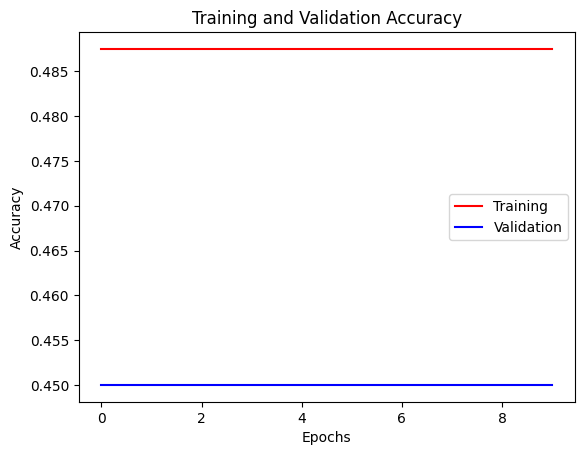

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

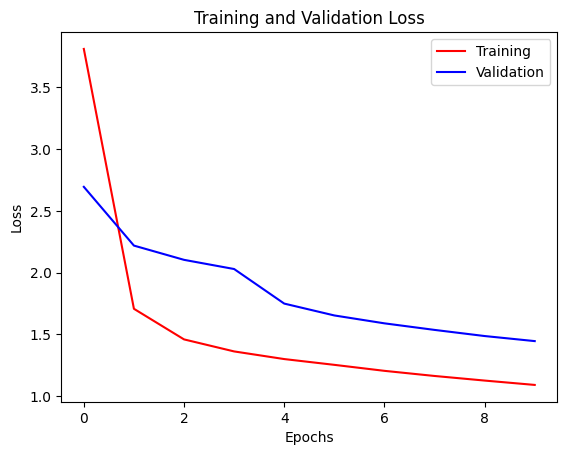

In [ ]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
# Evaluate the model on the test data
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 1.2591 - acc: 0.5000


[1.2591363191604614, 0.5]

In [ ]:
# The model's accuracy is 50.0% and the model's loss is 1.26.